<div style='background-image: url("https://www.geophysik.uni-muenchen.de/ROMY/theme/images/ringlaser_wideformat.jpg") ; padding: 0px ; background-size: cover ; border-radius: 15px ; height: 250px; background-position: 0% 80%'>
    <div style="float: left ; margin: 50px ; padding: 60px ; background: rgba(255 , 255 , 255 , 0.9) ; width: 40% ; height: 180px">
        <div style="position: relative ; top: 50%;  transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.9) ; line-height: 100%"> <br>  Snythetic Modulation <br> <br> Test Modulation Index </div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.7)"></div>
        </div>
    </div>

## Import Libraries

### Official Libraries

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import time
import pickle

from scipy.signal import resample, hilbert, correlate, decimate
from tqdm import tqdm
from obspy import UTCDateTime, read, read_inventory, Trace

### Own Processing Methods

In [2]:
import sys
sys.path.insert(0, 'submodules')

In [3]:
from EchoPerformance import __echo_performance
from CreateSyntheticEventV2 import __create_synthetic_event_v2
from MakeplotDemodulationQuality import __makeplot_demodulation_quality
from MinimizeResidual import __minimize_residual
from CreateLinearChirp import __create_linear_chirp
from Tapering import __tapering
from InstaFreqHilbert import __insta_freq_hilbert
from Normalize import __normalize
from WriteToMseed import __write_to_mseed
from LoadMseed import __load_mseed
from Modulation import __modulation
from QuerrySeismoData import __querry_seismo_data
from Interpolation import __interpolation

In [4]:
from RingLaser import RingLaser

## define G-Ring
G = RingLaser(side=4., form="square", wl=632.8e-9, lat=49.16)

## define ROMY Z-Ring
ROMY_Z = RingLaser(side=11., form="triangle", wl=632.8e-9, lat=49.16)


### Own Plotting Methods

In [5]:
from MakeplotTraceAndSpectrum import __makeplot_trace_and_spectrum
from MakeplotTraceAndPSD import __makeplot_trace_and_psd
from MakeplotModulatedSignal import __makeplot_modulated_signal

In [6]:

def __downsample(signal_in, sps, ds_factor=2):
    
    
#     tmp = Trace(signal_in)
#     tmp.stats.delta = 1/sps
    
#     tmp.resample(int(sps/2)) # using FFT
    
#     tmp.filter('lowpass', freq=2400, corners=8, zerophase=True)
#     signal_out = tmp.data

    signal_out = decimate(signal_in, ds_factor, n=None, ftype='fir', axis=-1, zero_phase=True)
    
    sps = int(sps/ds_factor)
    
#     signal_out = signal_out[::ds_factor]
    time_out = np.arange(signal_out.size)/sps

    return signal_out, time_out, sps


In [7]:

def __upsample_FIR(signal_in, sampling_factor, sps):
    
    from scipy.signal import upfirdn, resample_poly
    
    
    lower = 50
    upper = sampling_factor*lower
    
    signal_out = resample_poly(signal_in, upper, lower)
    
    time_out = np.arange(len(signal_out))/(sps*sampling_factor)
    
    return signal_out, time_out


## Configurations

In [8]:
# config = {}

## time period
T = 1600  ## seconds

## samles per second
sps = 5000

print(f"Total Samples: {T*sps}")


# sgnc = round(ROMY_Z.get_sagnac_frequency(), 2)
sgnc = 553.37
print(f"Rounded Sagnac Frequency: {round(sgnc,2)} Hz")




## decide if oversampling is set (bool) and how much oversampling
oversampling = True
oversampling_factor = 4

Total Samples: 8000000
Rounded Sagnac Frequency: 553.37 Hz


## Real Data from recorded Events

In [9]:
from obspy import UTCDateTime
from andbro__querrySeismoData import __querrySeismoData

## Kermadec Event
# tbeg = UTCDateTime("2021-03-04 18:40")
# tend = UTCDateTime("2021-03-04 18:40")+T
# f_lower, f_upper = 0.001, 0.1

## (possibly) Eigenmodes
# tbeg = UTCDateTime("2021-03-04 18:58")
# tend = UTCDateTime("2021-03-04 18:58")+T
# f_lower, f_upper = 0.003, 0.01

## Greece Event
tbeg = UTCDateTime("2021-03-03 10:18")
tend = UTCDateTime("2021-03-03 10:18")+T
f_lower, f_upper = 0.01, 0.5


## car / ambient noise - high frequent
# tbeg = UTCDateTime("2021-03-10 12:00")
# tend = UTCDateTime("2021-03-10 12:00")+T
# f_lower, f_upper = 1.0, 10.0


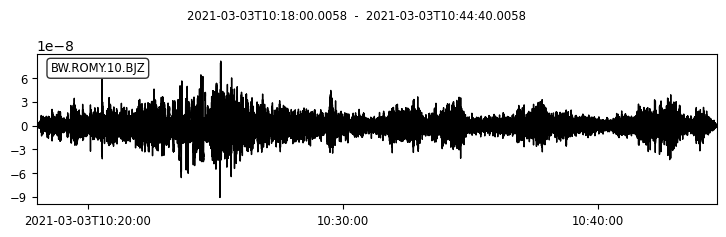

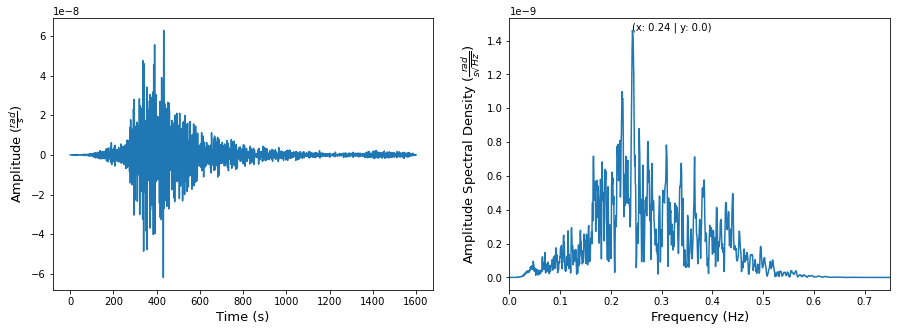

In [10]:
st, inv = __querrySeismoData(    
                            seed_id='BW.ROMY.10.BJZ',
                            starttime=tbeg,
                            endtime=tend,
                            where="george",
                            path=None,
                            restitute=True,
                            detail=None,
                             )
st.plot();

## narrow signal to specified frequency band
st.filter('bandpass', freqmin=f_lower, freqmax=f_upper, corners=8, zerophase=True)

## get data from stream
modeltrace = st[0].data

## generate a time axis for the model
time_modeltrace = np.arange(modeltrace.size)/st[0].stats.sampling_rate

## free some space
del st

## plot the trace and amplitude spectrum
__makeplot_trace_and_spectrum(modeltrace, time_modeltrace, fmax=1.5*f_upper); 

## Upsample the signal

In [11]:
if oversampling:
    
    ## upsample using FIR filter
#     modeltrace, time_modeltrace = __upsample_FIR(modeltrace, oversampling_factor, sps)

    ## upsample using interpolation method
    modeltrace, time_modeltrace = __interpolation(modeltrace, time_modeltrace, T, oversampling_factor*sps)
    
    ## adjust sps value
    sps *= oversampling_factor

## check size of arrays
modeltrace.size, time_modeltrace.size

modeltrace is interpolated: 32001 samples --> 32000001 samples


(32000001, 32000001)

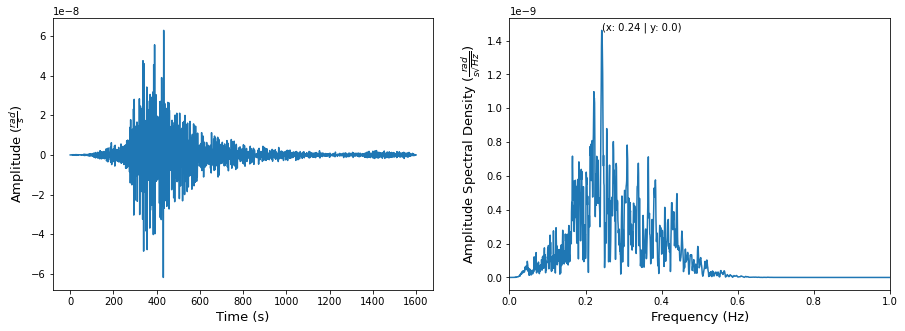

In [12]:
__makeplot_trace_and_spectrum(modeltrace, time_modeltrace, fmax=1, text=True); 

# Modulation - with loop over Modulation Index

In [13]:
variation = np.array([-0.5, -0.3, -0.1, 0.0, 0.1, 0.3, 0.5])

modulation_indicies = (np.ones(len(variation)) + variation)*ROMY_Z.get_scale_factor()

modulation_scheme = 3

sps0 = sps

In [14]:
signals = []


for i, mod_idx in enumerate(modulation_indicies):

    synthetic_signal, timeline = __modulation(
                                              modeltrace,
                                              time_modeltrace, 
                                              sgnc, 
                                              T, 
                                              sps0, 
                                              mod_idx, 
                                              modulation_scheme,
                                             )

    ## taper
    synthetic_signal = __tapering(synthetic_signal, taper_type='hann', percent=0.2)
    
    
    ## downsample
    if oversampling:

        ## downsample synthetic
        synthetic_signal, timeline, sps = __downsample(synthetic_signal, sps0, ds_factor=oversampling_factor)
        
    signals.append(synthetic_signal)


Modulation option 3 is executed ...

 --> integrating ... 

 elapsed time: 11.66 sec

Modulation option 3 is executed ...

 --> integrating ... 

 elapsed time: 10.96 sec

Modulation option 3 is executed ...

 --> integrating ... 

 elapsed time: 10.93 sec

Modulation option 3 is executed ...

 --> integrating ... 

 elapsed time: 11.02 sec

Modulation option 3 is executed ...

 --> integrating ... 

 elapsed time: 11.07 sec

Modulation option 3 is executed ...

 --> integrating ... 

 elapsed time: 11.12 sec

Modulation option 3 is executed ...

 --> integrating ... 

 elapsed time: 10.93 sec


In [15]:
from submodules.FastFourierTransform import __fast_fourier_transform


from numpy.fft import fftshift
from scipy.signal import welch
from random import uniform

# noise_level = [0, 0.01, 0.1, 0.5, 1, 2]
noise_level = np.logspace(-2, 1, 5) 
noise_level = np.insert(noise_level,0, 0)

snr = []
spectra = []

sps0 = sps ## prevent overwriting

for synthetic_signal in signals:
    
    N = len(synthetic_signal)
    
    ## add noise to modulated signal
#     random_noise = np.random.randn(size=N)*nl
#     random_noise = np.array([uniform(-1, 1) for i in range(N)])*nl

#     syn_noise = synthetic_signal + random_noise
    
    
    ## compute SNR
#     print(np.mean(abs(synthetic_signal))/np.mean(abs(random_noise)), np.mean(abs(synthetic_signal)/abs(random_noise)))
#     signal_to_noise = 20*np.log10(np.mean(abs(synthetic_signal))/np.mean(abs(random_noise)))
    
#     if signal_to_noise == np.nan:
#         snr.append(0)
#     else:
#         snr.append(signal_to_noise)
        
    ## compute spectrum
#     trace_fft, ff = __fast_fourier_transform(signal_in=syn_noise, dt=1/sps , window=None, normalize=None)
#     spectra.append(abs(trace_fft[:N // 2]))
#     freqs = ff[:N // 2]

    ## compute psd
    freqs, signal_psd = welch(synthetic_signal, sps, return_onesided=False, nperseg=1e6, scaling="density")
    freqs = fftshift(freqs)
    
    spectra.append(abs(fftshift(signal_psd)))  
    

## Get Raw Signal for Comparison

Coordinates could not be attached! Inventory not complete!


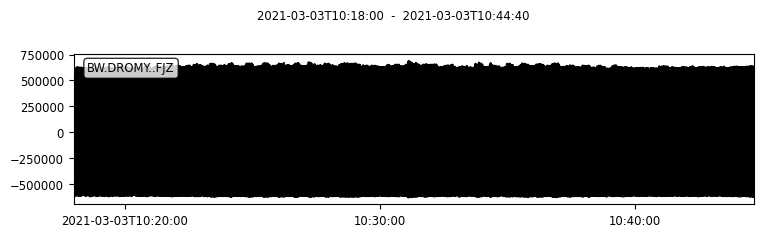

In [16]:
try: 
    print(st0)
except:
    st0, inv = __querrySeismoData( 
                                seed_id='BW.DROMY..FJZ',
                                starttime=tbeg,
                                endtime=tend,
                                where="george",
                                path=None,
                                restitute=True,
                                detail=None,
                                 )

    ## remove DC offset
    st0.detrend('demean')

## show data
st0.plot();

In [17]:
## get data from stream
rawtrace = st0[0].data

rawtrace = __normalize(rawtrace)

## generate a time axis for the model
time_rawtrace = np.arange(rawtrace.size)/st0[0].stats.sampling_rate

## get PSD
raw_freqs, raw_psd = welch(rawtrace, st0[0].stats.sampling_rate, return_onesided=False, nperseg=1e6, scaling="density")
raw_freqs = fftshift(raw_freqs)
raw_psd = abs(fftshift(raw_psd)) 

# Plot

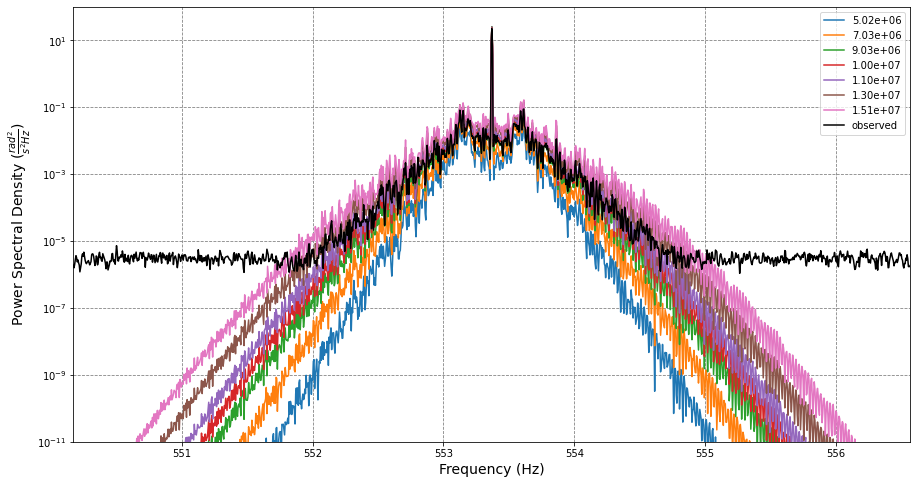

In [21]:
def __makeplot_modidx(text=True):

    font =  12
    f_range = 3.2 # plusminus
    
    
    ## ---------------------------------
    
    fig, ax = plt.subplots(1, 1, figsize=(15,8))

    font = 14

    for ss, mi in zip(spectra, modulation_indicies):
        ax.plot(freqs, ss, zorder=2, label=f'{mi:.2e}')
        ax.set_yscale('log')

    try:
        ax.plot(raw_freqs, raw_psd, zorder=2, label='observed',color='k')
    except Exception as e:
        print(e)

    if text:
        max_y, max_x = max(raw_psd), abs(raw_freqs[np.argmax(raw_psd)])
        print(f' x: {max_x} \n y: {max_y}')
        ax.annotate(f'(x: {round(max_x,2)} | y: {round(max_y,5)})', xy=(max_x, max_y), xytext=(max_x, max_y))

    ax.legend(loc="upper right")
    ax.grid(color="grey", ls="--", zorder=0)

    ax.set_xlim(sgnc-f_range, sgnc+f_range)
    ax.set_ylim(1e-11, 1e2)

    ax.set_xlabel("Frequency (Hz)", fontsize=font)
    ax.set_ylabel(r"Power Spectral Density ($\frac{rad^2}{s^2 Hz }$)", fontsize=font)
    
    plt.show();
    return fig

__makeplot_modidx(text=False);

## Write 

In [19]:
# ## store synthetic trace
# oname = "realtrace" 
# ofile = open(f"/home/andbro/notebooks/Sagnac_processing/data/{oname}.syn","wb")
# pickle.dump(synthetic_signal, ofile)
# ofile.close()

# ## store model trace
# ofile = open(f"/home/andbro/notebooks/Sagnac_processing/data/{oname}.mod","wb")
# pickle.dump(modeltrace, ofile)
# ofile.close()